In [1]:
import os
import numpy as np 
import pandas as pd 
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

# Import and process data
Import the reference table and k-hot encode the labels

In [2]:
xray_data=pd.read_csv("C:\\Users\\alex.hall\\Documents\\datasets\\xray\\Data_Entry_2017.csv\\Data_Entry_2017.csv")
labels_list=xray_data['Finding Labels'].str.cat(sep='|').split('|')
unique_labels=list(set(labels_list))

y_true=np.zeros(shape=(np.shape(xray_data)[0],len(unique_labels)))

for i in range(0,len(y_true)-1):
    for j in range(0,len(unique_labels)-1):
        if(unique_labels[j] in xray_data['Finding Labels'][i]):
            y_true[i,j]=1

    

Import the photos as a np array


(1024, 1024)


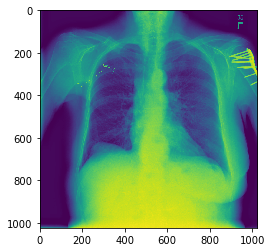

In [3]:
#print a sample image
%matplotlib inline
test_img=Image.open('C:\\Users\\alex.hall\\Documents\\datasets\\xray\\images_001\\images\\' + xray_data['Image Index'][10])
test_img_array=np.array(test_img)
print(np.shape(test_img_array))
plt.imshow(test_img)

Import all the images ans split into train and test sets
note the images are already shuffled so we don't need to worry about changing the order here


In [4]:

import os
number_images=len(os.listdir('C:\\Users\\alex.hall\\Documents\\datasets\\xray\\images_001\\images\\')) #ie the total number of images
y=list()
x=list()
for i in range(0,int(np.shape(xray_data)[0])):
    try:
        if(np.shape(np.array(Image.open('C:\\Users\\alex.hall\\Documents\\datasets\\xray\\images_001\\images\\' + xray_data['Image Index'][i])))==(1024,1024)):
            x.append(np.array(Image.open('C:\\Users\\alex.hall\\Documents\\datasets\\xray\\images_001\\images\\' + xray_data['Image Index'][i])))
            y.append(y_true[[i]])
    except:
        pass
  

    
x_train=np.array(x[0:int(0.7*len(x))])
y_train=np.array(y[0:int(0.7*len(y))])
x_test=np.array(x[int(0.7*len(x)):len(x)])
y_test=np.array(y[int(0.7*len(y)):len(y)])

In [5]:
import tensorflow as tf

# Create Model

In [6]:
x = tf.placeholder(tf.float32,shape=[None,1024,1024])
y_true = tf.placeholder(tf.float32,shape=[None,1,15])
dropprob = tf.placeholder(tf.float32) #used for dropout

Helper functions for creating the model

In [7]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 8, 8, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# Create CNN layers

In [8]:
x_image = tf.reshape(x,[-1,1024,1024,1])

convo_1 = convolutional_layer(x_image,shape=[64,64,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling,shape=[32,32,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

#  pooling layers, so (696/2)/2 = 174 . 520/2/2 = 130. Note, we would need far more conv layers in a real
#life application but this would require a lot of runtime
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,1*1*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

#placeholders for dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

#output layer
y_pred = normal_full_layer(full_one_dropout,15)

# Loss function and optimiser

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

# Run Session

In [ ]:
import random
init = tf.global_variables_initializer()

steps = 100

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        batch_indices=random.sample(range(0,np.shape(x_train)[0]), 10)
        batch_x  = x_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%1 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:x_test,y_true:y_test,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
